In [1]:
#Carregando as funções
setwd("C:/Users/User/OneDrive/Documentos")
source("Meus Arquivos/Códigos/Carteira.R", encoding = "UTF-8")
source("Meus Arquivos/Códigos/Funções.R",encoding = "UTF-8")
source("Meus Arquivos/Códigos/MSGARCH fitting.R")
source("Meus Arquivos/Códigos/Garch fitting.R")

In [2]:
#Carregando os pacotes
options(scipen = 999)
pacotes <- c("tidyverse","BatchGetSymbols","ggalluvial","rugarch","MSGARCH")
suppressPackageStartupMessages(sapply(pacotes,require,character.only = T))

tidyverse BatchGetSymbols      ggalluvial         rugarch         MSGARCH 
           TRUE            TRUE            TRUE            TRUE            TRUE

In [3]:
#Lista com data.frames de negociação dos ativos
lista <- readRDS("Listas R/lista_gabriel.rds")

In [6]:
#Consolidando a carteira
if(!is.null(lista)){
  total_carteira <- NA
  i <- 1
}
while(is.na(total_carteira) & i <= 3){
  try(total_carteira <- carteira_tot(lista,valores_atual = T,be.quiet = F,
                            do_cache = T,ret_dividendos = T,
                            data.frame_ativos = T,finalizados = T,
                            download.td = F,paga_td = T) %>% suppressMessages)
  i <- i+1
}


Reading xls data and saving to data.frame
 Reading File = TD Files/NTN-B Principal_2005.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2005.xls
 Reading File = TD Files/NTN-B Principal_2006.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2006.xls
 Reading File = TD Files/NTN-B Principal_2007.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2007.xls
 Reading File = TD Files/NTN-B Principal_2008.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2008.xls
 Reading File = TD Files/NTN-B Principal_2009.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2009.xls
 Reading File = TD Files/NTN-B Principal_2010.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2010.xls
 Reading File = TD Files/NTN-B Principal_2011.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2011.xls
 Reading File = TD Files/NTN-B Principal_2012.xls
    Cant find maturities in file  TD Files/NTN-B Principal_2012.xls
 Reading File

In [7]:
total_r <- total_carteira[[1]] %>%
  mutate(drawdown = (c(1,retorno_tot+1)/
           cummax(c(1,retorno_tot+1)))[-1]-1,
         retorno_s = retorno_carteira(valor_tot,aporte,compras,ret_dividendos = F),
         retorno_tot_s = cumprod(retorno_s+1)-1)
pesos_t <- total_carteira$pesos
total_carteira$pesos <- NULL
#Carteira de referência
total <- total_r %>%
  filter(retorno != 0)
pesos <- pesos_t %>%
  filter(retorno != 0)

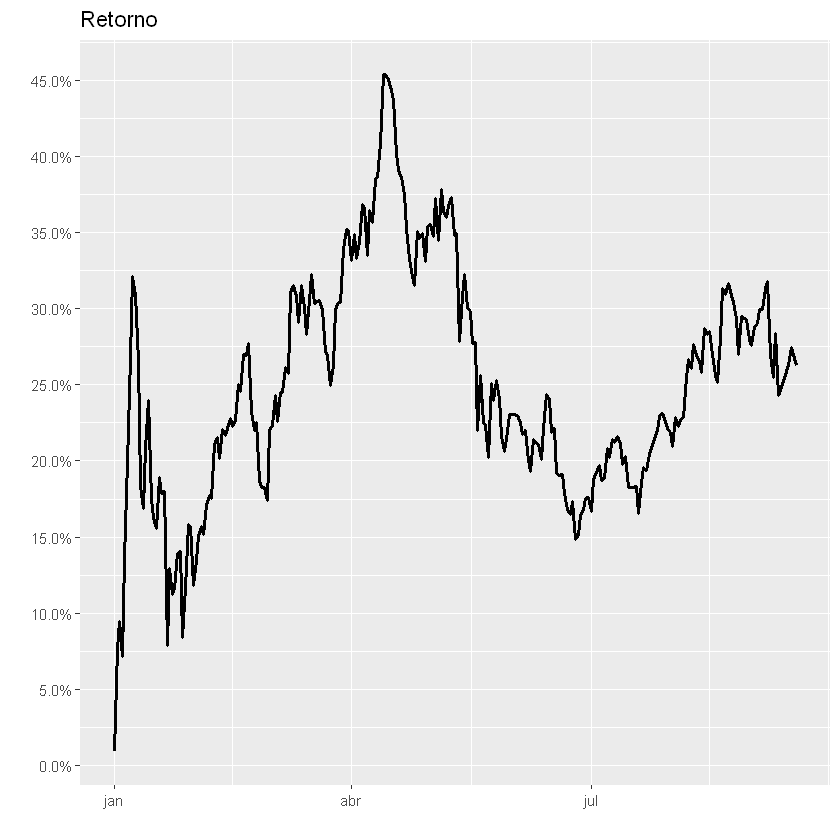

In [8]:
#Plots
data_inicio <- "2021-01-01"
data_fim <- Sys.Date()
#Retorno total
ggplot(total %>% filter(date >= data_inicio & 
                          date <= data_fim & retorno != 0) %>%
         mutate(retorno_tot = cumprod(retorno+1)-1,
                retorno_tot_s = cumprod(retorno_s+1)-1),
       aes(x = date))+
  geom_line(aes(y = retorno_tot),size = 1)+
  labs(x = "", y = "", title = "Retorno")+
  scale_y_continuous(labels = scales::percent,
                     n.breaks = 13)

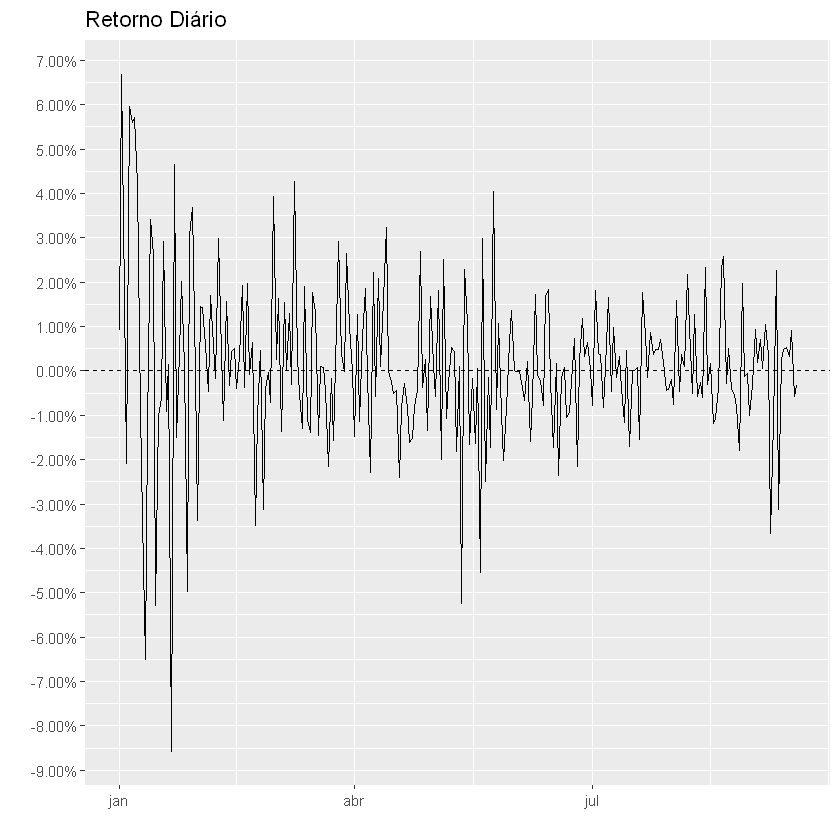

In [9]:
#Retorno diário
ggplot(total %>% filter(date >= data_inicio & 
                          date <= data_fim & retorno != 0),
       aes(x = date, y = retorno))+
  geom_line()+
  labs(x = "", y = "", title = "Retorno Diário")+
  scale_y_continuous(labels = scales::percent, n.breaks = 13)+
  geom_hline(yintercept = 0, lty = 2)

In [10]:
#GARCH e MSGARCH fitting
total_xts <- total %>% filter(retorno != 0 & date <= max(date))
total_xts <- xts(total_xts$retorno,total_xts$date)
data_f <- tail(index(total_xts),1)
ugspec <- ugarchspec(variance.model = list(model = "iGARCH",garchOrder = c(1,1)),
                     mean.model = list(armaOrder = c(1,0)),distribution.model = "std") #Garch Spec
spec_garch <- ugspec
spec <- CreateSpec(variance.spec = list(model = c("gjrGARCH","eGARCH")),
                   distribution.spec = list(distribution = c("snorm","sstd"))) #MSGARCH Spec
spec_ms <- spec
n_roll <- 0
n_fore <- 5
fit <- ugarchfit(spec_garch,total_xts, out.sample = n_roll) #GARCH Fit

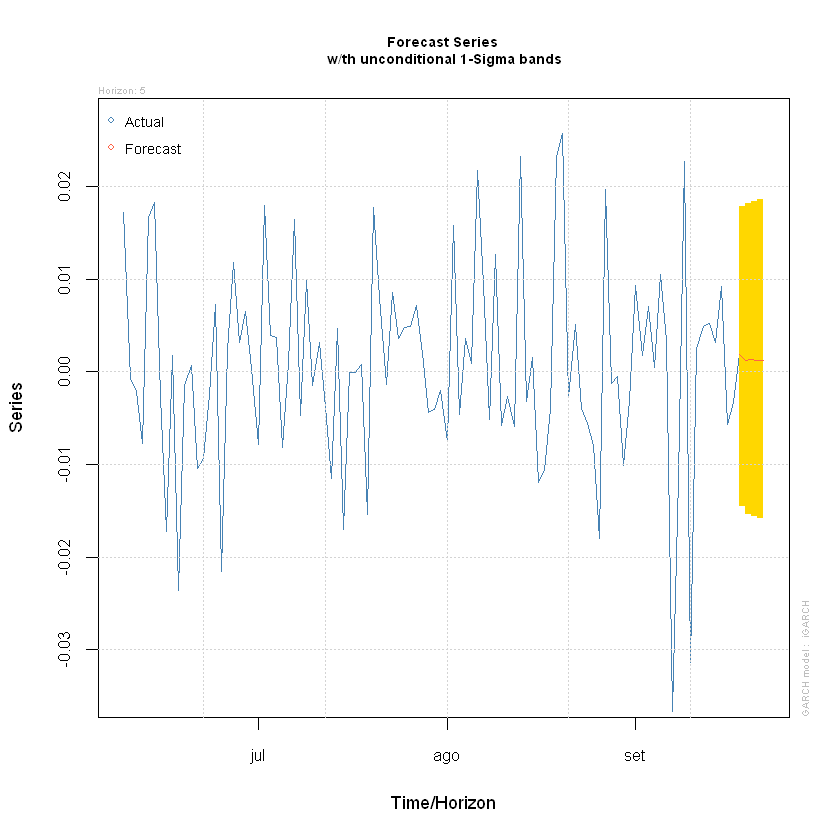

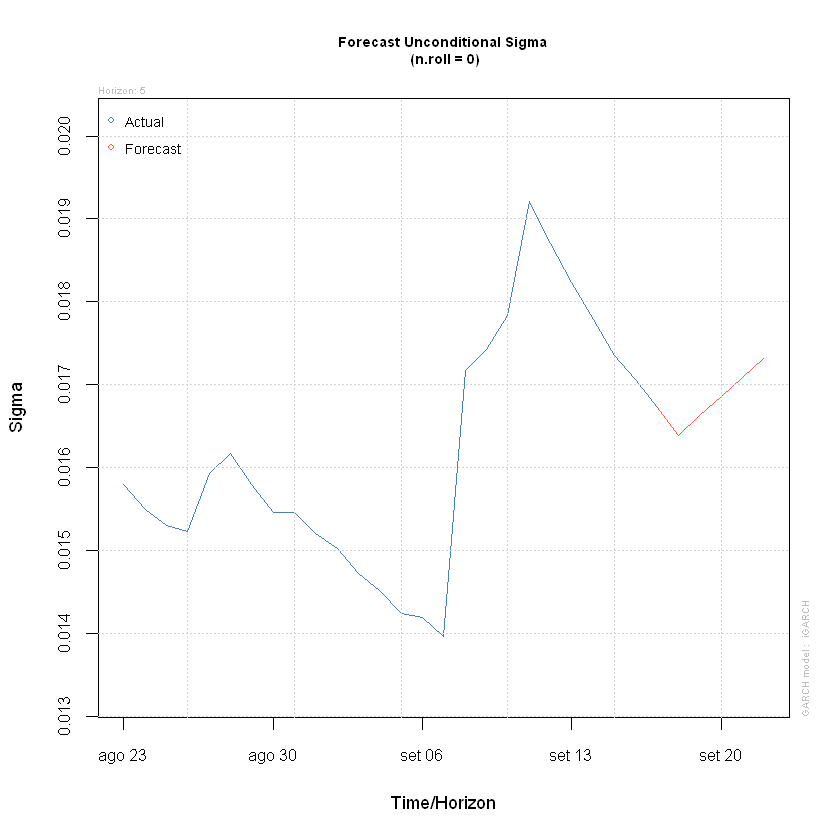

In [11]:
fore <- ugarchforecast(fit, data = total_xts, n.roll = n_roll,n.ahead = n_fore) #Previsão de retorno e risco
plot(fore,which = 1)
plot(fore,which = 3)

In [12]:
sig <- fit@fit$sigma
cond_vol_garch <- sig[1]
fit_ms <- FitML(spec_ms, total_xts, 
                ctr = list(OptimFUN = optim_fun,
                           do.plm = T)) #MSGARCH fit
fore_ms <- predict(fit_ms,nahead = n_fore,do.return.draw = T, do.cumulative = T)
vol_fore <- fore_ms$vol
vol_ms <- Volatility(fit_ms)
cond_vol_ms <- sqrt(mean(vol_ms^2))

In [13]:
#Data.frame das volatilidades
var <- Risk(fit_ms, alpha = c(0.05,0.95), do.its = T, do.es = F)[[1]]
sig1 <- data.frame(date = index(total_xts), 
                   retorno = total_xts %>% as.numeric, 
                   type = "GARCH",
                   vol = sig,
                   vol_cond = cond_vol_garch,
                   var5 = quantile(fit,0.05) %>% as.numeric,
                   var95 = quantile(fit,0.95) %>% as.numeric) %>%
  rbind(data.frame(date = index(total_xts), 
                   retorno = total_xts %>% as.numeric,
                   type = "MSGARCH",
                   vol = vol_ms,
                   vol_cond = cond_vol_ms,
                   var5 =  var$`0.05`,
                   var95 = var$`0.95`)) %>%
  mutate(col = ifelse(retorno >= var95|retorno <= var5%>%
                        as.numeric,"black",NA)) %>%
  filter(retorno != 0)

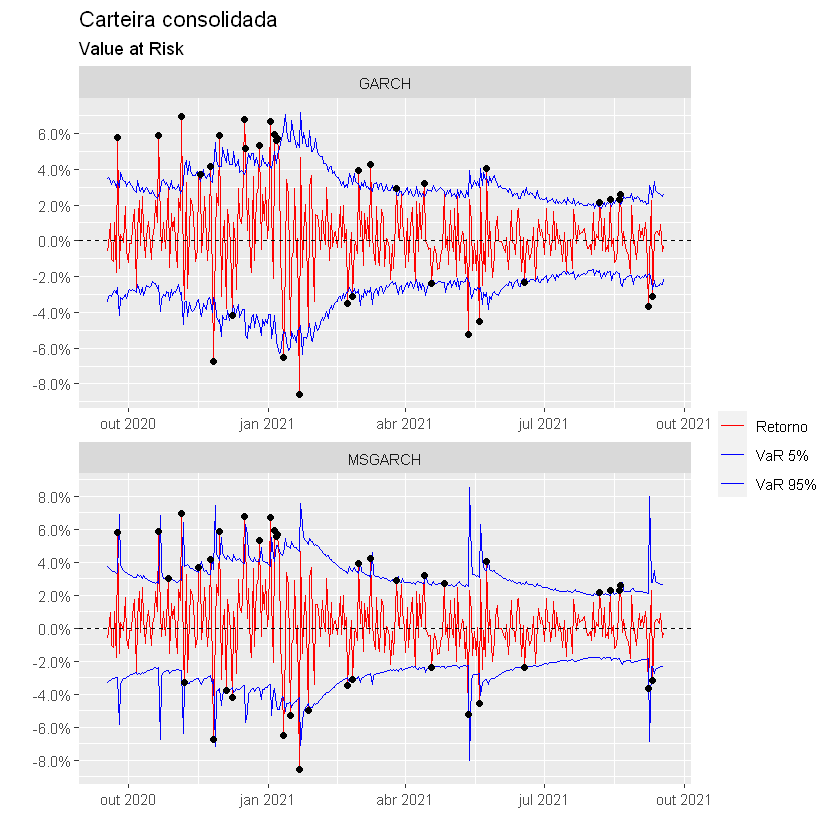

In [14]:
#Plots
data <- Sys.Date()-dmonths(12)
#VaR
ggplot(sig1 %>%
         filter(date >= data),
       aes(x = date, group = type))+
  geom_line(aes(y = retorno, col = "Retorno"))+
  geom_line(aes(y = var5, col = "VaR 5%"))+
  geom_line(aes(y = var95, col = "VaR 95%"))+
  geom_point(aes(y = retorno),
             col = sig1$col[sig1$date >= data])+
  geom_hline(yintercept = 0, lty = 2)+
  labs(x = "", y = "", title = "Carteira consolidada",
       subtitle = "Value at Risk")+
  scale_y_continuous(labels = scales::percent, n.breaks = 10)+
  scale_color_manual("",values = c("red","blue","blue"))+
  facet_wrap(~type, nrow = 2, scales = 'free')

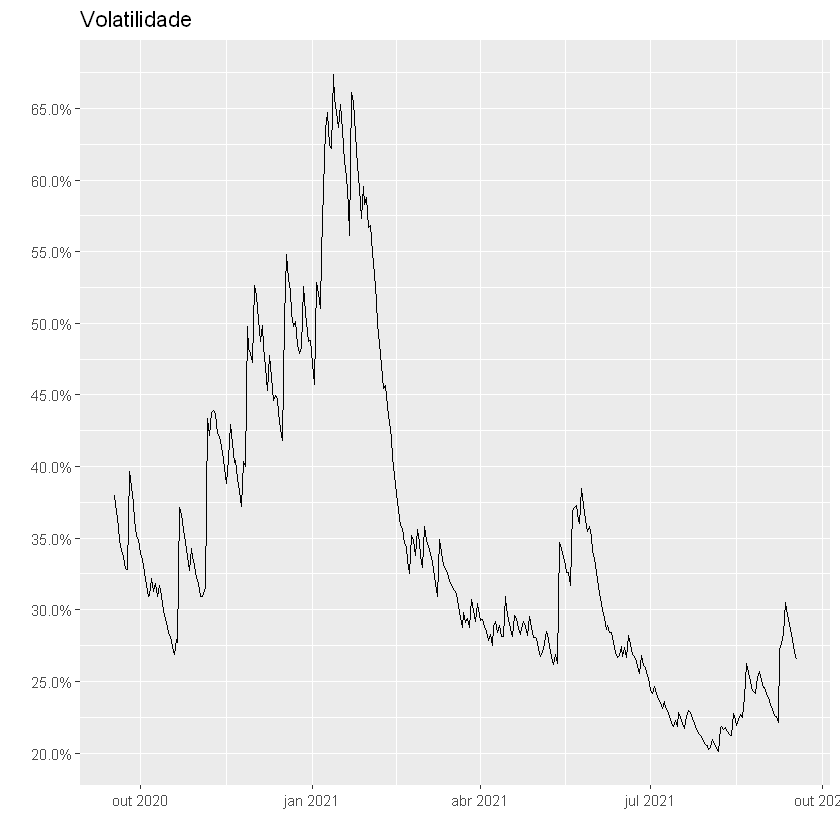

In [15]:
#Volatilidade da carteira
ggplot(sig1 %>% 
         filter(date >= data & type == "GARCH"),
       aes(x = date))+
  geom_line(aes(y = vol*sqrt(252)))+
  labs(x = "", y = "", title = "Volatilidade")+
  scale_y_continuous(labels = scales::percent, n.breaks = 13)

In [16]:
#GARCH Simulation
n_sim <- 10000
dias <- 30
sim <- ugarchsim(fit,n.sim = dias,m.sim = n_sim, startMethod = "sample")
sim1 <- sim@simulation$seriesSim #Simulação dos retornos
sim_sd <- sim@simulation$sigmaSim #Simulação da volatilidade
sim1 <- apply(sim1+1,2,cumprod) #Retorno acumulado
dias_uteis <- all(bizdays::is.bizday(tail(index(total_xts),30),"Brazil/ANBIMA"))
if(dias_uteis){
  datas <- bizdays::add.bizdays(data_f,1:dias)
}else{
  datas <- data_f+1:dias
}

In [17]:
sim1 <- sim1 %>%
  as.data.frame() %>%
  mutate(date = datas) %>%
  gather(key = "sim", value = "value", -date)
sim_sd <- sim_sd %>%
  as.data.frame() %>%
  mutate(date = datas) %>%
  gather(key = "sim", value = "value", -date)
quantias_sd <- sim_sd %>% #Quartis da volatilidade dia a dia
          select(date,value) %>%
  group_by(date) %>%
  summarise(`5%` = quantile(value,0.05),
            "10%" = quantile(value,0.1),
            `30%` = quantile(value,0.4),
            `50%` = quantile(value,0.5),
            `70%` = quantile(value,0.6),
            "90%" = quantile(value,0.9),
            `95%` = quantile(value,0.95)) %>%
  gather(key = "quantis", value = "value", -date) %>%
  rbind(data.frame(date = index(total_xts),
             quantis = "Real",
             value = fit@fit$sigma)) %>%
  na.omit %>%
  arrange(date)
quantias <- rbind(sim1 %>% #Quartis dos retornos acumulados e retorno histórico
                    mutate(sim = NULL,
                           value = value*prod(total_xts+1)-1)%>%
  group_by(date) %>%
  summarise(`5%` = quantile(value,0.05),
            "10%" = quantile(value,0.1),
            `30%` = quantile(value,0.4),
            `50%` = quantile(value,0.5),
            `70%` = quantile(value,0.6),
            "90%" = quantile(value,0.9),
            `95%` = quantile(value,0.95)) %>%
  gather(key = "quantis", value = "value", -date),
  total %>%
    select(date,retorno_tot) %>%
    filter(date <= data_f) %>%
    dplyr::rename(value = retorno_tot) %>%
    mutate(quantis = "Real")) %>%
  na.omit %>%
  arrange(date)
quantias1 <- sim1 %>% #Quartis dos retornos acumulados
  group_by(date) %>%
  summarise(`5%` = quantile(value,0.05)-1,
            "10%" = quantile(value,0.1)-1,
            `30%` = quantile(value,0.4)-1,
            `50%` = quantile(value,0.5)-1,
            `70%` = quantile(value,0.6)-1,
            "90%" = quantile(value,0.9)-1,
            `95%` = quantile(value,0.95)-1) %>%
  gather(key = "quantis", value = "value", -date)

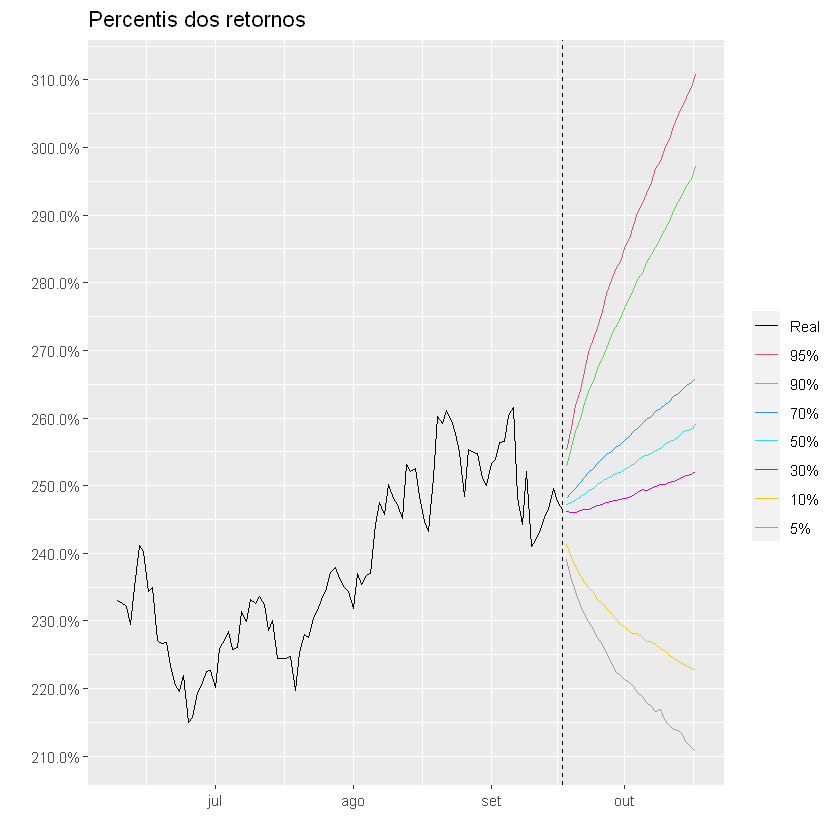

In [18]:
dias_plot <- 100
fatores <- c("5%","10%","30%","50%","70%","90%","95%","Real")
ggplot(quantias %>%
         filter(date >= data_f-dias_plot),
       aes(x = date, y = value, col = quantis))+
  geom_line()+
  geom_vline(xintercept = data_f, lty = 2)+
  labs(x = "", y = "", title = "Percentis dos retornos")+
  scale_y_continuous(labels = scales::percent,
                     n.breaks = 13)+
  scale_color_manual("", breaks = fatores[length(fatores):1],
                     values = 1:length(fatores))

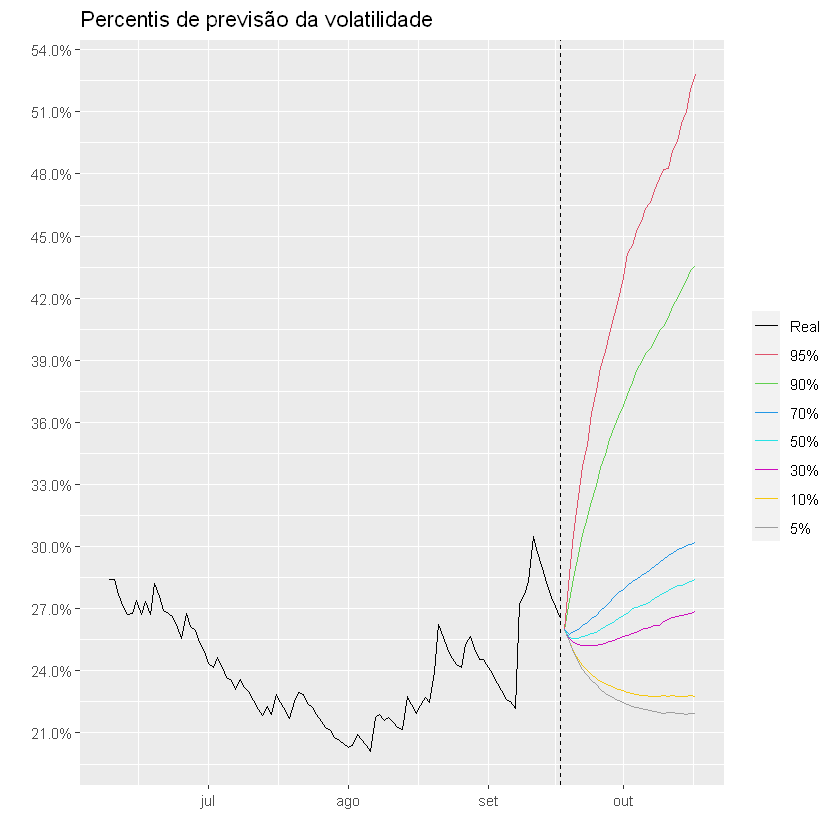

In [19]:
ggplot(quantias_sd %>%
         filter(date >= data_f-dias_plot),
       aes(x = date, y = value*sqrt(252), col = quantis))+
  geom_line()+
  geom_vline(xintercept = data_f, lty = 2)+
  labs(x = "", y = "", title = "Percentis de previsão da volatilidade")+
  scale_y_continuous(labels = scales::percent,
                     n.breaks = 13)+
  scale_color_manual("", breaks = fatores[length(fatores):1],
                     values = 1:length(fatores))

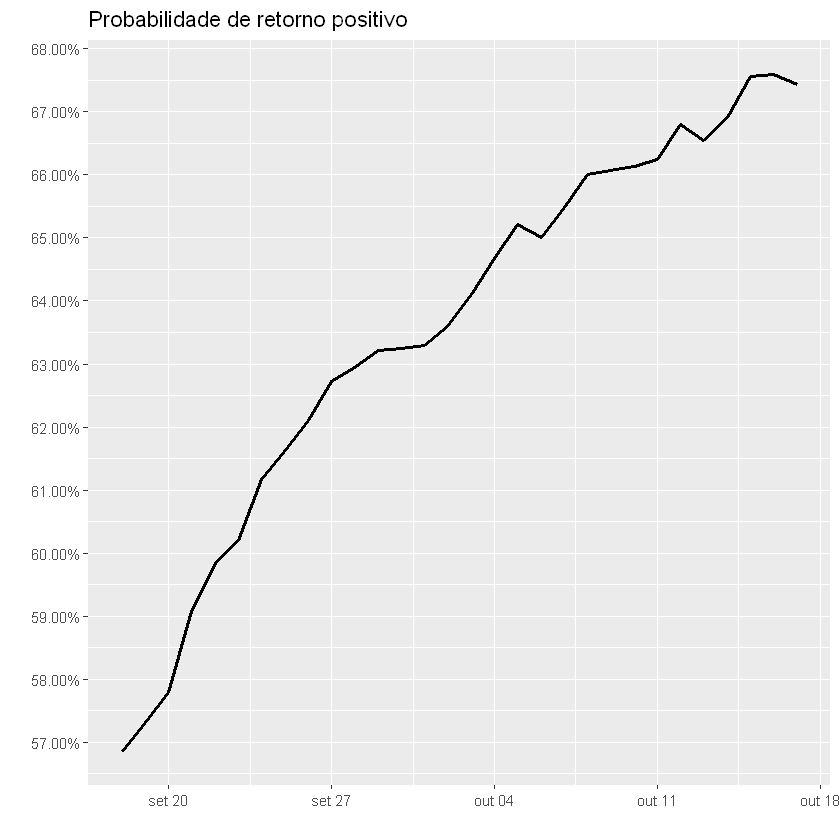

In [20]:
prob <- sim1 %>%
  group_by(date) %>%
  summarise(prob = mean(value > 1))
ggplot(prob, aes(x = date, y = prob))+
  geom_line(size = 1)+
  labs(x = "", y = "", title = "Probabilidade de retorno positivo")+
  scale_y_continuous(labels = scales::percent, n.breaks = 13)